In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from adjustText import adjust_text
import contextily as ctx
from sklearn.preprocessing import MinMaxScaler
from scipy.stats.mstats import winsorize
import json
from mpl_toolkits.axes_grid1 import Divider, Size


In [2]:
data = pd.read_excel('visual_SD_div.xlsx')

# dropping out AK and HI for map readability
data = data.drop(data[data['stateabb'] == 'AK'].index)
data = data.drop(data[data['stateabb'] == 'HI'].index)

data['x'] = MinMaxScaler((0, 1)).fit_transform(data['poldiv'].values.reshape(-1,1))
data['y'] = MinMaxScaler((0, 1)).fit_transform(data['sd_index'].values.reshape(-1,1))

data['GEO_ID'] = data.apply(lambda x: '0' + str(x['fipsmerg']) if len(str(x['fipsmerg'])) < 5 else str(x['fipsmerg']), axis=1)
data['GEO_ID'] = data.apply(lambda x: '0500000US' + str(x['GEO_ID']), axis=1)

In [3]:
border = gpd.read_file('gz_2010_us_050_00_500k')
border = border.drop(border[border['STATE'] == '15'].index)
border = border.drop(border[border['STATE'] == '02'].index)
border = border.drop(border[border['STATE'] == '72'].index)


data = border.merge(data, on='GEO_ID')

#with open('gz_2010_us_050_00_500k.json', 'r') as geojson_file:
#    border = json.load(geojson_file)

In [4]:
# Define the bins
#bins = [0, 0.25, 0.5, 0.75, 1]
xbins = list(data['x'].quantile([0, 0.25, 0.5, 0.75, 1]))
ybins = list(data['y'].quantile([0, 0.25, 0.5, 0.75, 1]))

# Bin the first variable - x
data['Var1_Class'] = pd.cut(data['x'], bins=xbins, include_lowest=True)
data['Var1_Class'] = data['Var1_Class'].astype('str')

# Bin the second variable - y
data['Var2_Class'] = pd.cut(data['y'], bins=ybins, include_lowest=True)
data['Var2_Class'] = data['Var2_Class'].astype('str')

# Code created x bins to 1, 2, 3, 4
x_class_codes = np.arange(1, len(xbins))
d = dict(zip(data['Var1_Class'].value_counts().sort_index().index, x_class_codes))
data['Var1_Class'] = data['Var1_Class'].replace(d)

# Code created y bins to A, B, C, D
y_class_codes = ['A', 'B', 'C', 'D']
d = dict(zip(data['Var2_Class'].value_counts().sort_index().index, y_class_codes))
data['Var2_Class'] = data['Var2_Class'].replace(d)

# Combine x and y codes to create Bi_Class
data['Bi_Class'] = data['Var1_Class'].astype('str') + data['Var2_Class']

In [5]:
print('Number of unique elements in Var1_Class =', len(data['Var1_Class'].unique()))
print('Number of unique elements in Var2_Class =', len(data['Var2_Class'].unique()))
print('Number of unique elements in Bi_Class =', len(data['Bi_Class'].unique()))

#data[~(data['Var1_Class'].isin([1, 2, 3]))]

Number of unique elements in Var1_Class = 5
Number of unique elements in Var2_Class = 4
Number of unique elements in Bi_Class = 17


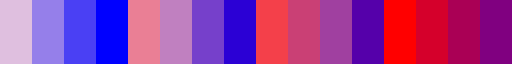

In [6]:
### ENTER COLORS HERE ###

all_colors = ['#DFBFDF', # 1A-
                '#957FEA', # 1B-
                '#4A40F4', # 1C-
                '#0000FF', # 1D-
                '#EA7F95', # 2A-
                '#C080C0', # 2B-
                '#7640CB', # 2C-
                '#2B00D5', # 2D-
                '#F4404A', # 3A-
                '#CA4075', # 3B-
                '#A040A0', # 3C-
                '#5500AA', # 3D-
                '#FF0000', # 4A-
                '#D5002B', # 4B-
                '#AA0055', # 4C-
                '#800080'] # 4D-

            
cmap = matplotlib.colors.ListedColormap(all_colors)
cmap

In [7]:
biclasses = ['1A', '1B', '1C', '1D', '2A', '2B', '2C', '2D', '3A', '3B', '3C', '3D', '4A', '4B', '4C', '4D']
classtocolor = dict(zip(biclasses, all_colors))

data['color'] = data.apply(lambda row: classtocolor.get(row['Bi_Class'], '#FFFFFF'), axis=1)

C:\Users\samyakj\AppData\Local\Temp\ipykernel_4652\2666019442.py:9: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  data.plot(ax=ax,


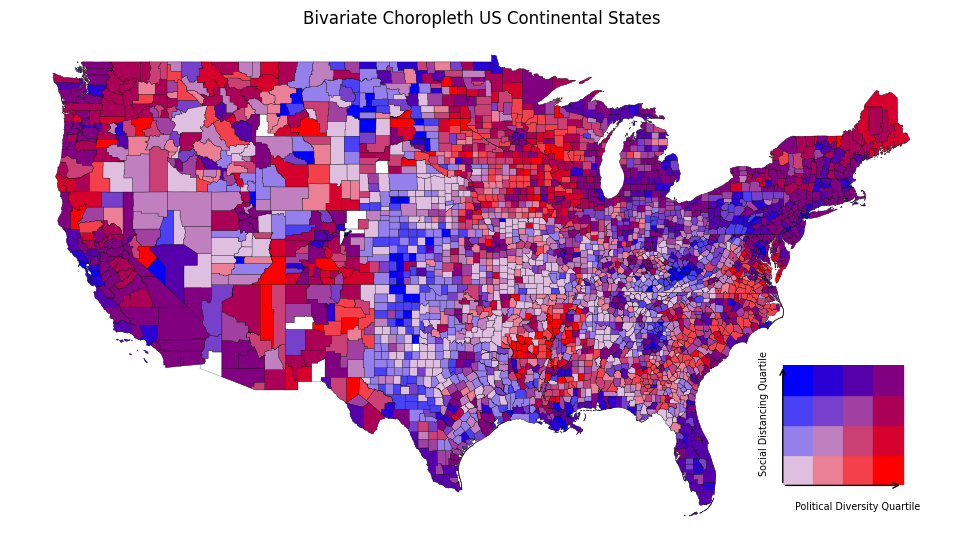

In [8]:
fig, ax = plt.subplots(figsize=(10,8))
#ax1 = fig.add_axes([0, 0, 3.5, 3.5]) # add new axes to place the legend there
matplotlib.rcParams['axes.linewidth'] = 1


# Step 1: Draw the map
border.plot(ax=ax, facecolor='none', edgecolor='black', alpha=0.5, linewidth=0.3) 

data.plot(ax=ax, 
          column='Bi_Class',
          color=data['color'], 
          categorical=True, 
          legend=False, 
          linewidth=0.2,
          edgecolor='black') 
#ctx.add_basemap(ax=ax1, source=ctx.providers.CartoDB.Positron) # add the basemap


plt.tight_layout()
plt.axis('off') 
ax.set_title('Bivariate Choropleth US Continental States')



# Step 2: draw the legend

img2 = fig
ax2 = fig.add_axes([0.8, 0.25, 0.15, 0.15])
alpha = 1 

# Column 1
ax2.axvspan(xmin=0, xmax=0.25, ymin=0, ymax=0.25, alpha=alpha, color=all_colors[0])
ax2.axvspan(xmin=0, xmax=0.25, ymin=0.25, ymax=0.5, alpha=alpha, color=all_colors[1])
ax2.axvspan(xmin=0, xmax=0.25, ymin=0.5, ymax=0.75, alpha=alpha, color=all_colors[2])
ax2.axvspan(xmin=0, xmax=0.25, ymin=0.75, ymax=1, alpha=alpha, color=all_colors[3])

# Column 2
ax2.axvspan(xmin=0.25, xmax=0.5, ymin=0, ymax=0.25, alpha=alpha, color=all_colors[4])
ax2.axvspan(xmin=0.25, xmax=0.5, ymin=0.25, ymax=0.5, alpha=alpha, color=all_colors[5])
ax2.axvspan(xmin=0.25, xmax=0.5, ymin=0.5, ymax=0.75, alpha=alpha, color=all_colors[6])
ax2.axvspan(xmin=0.25, xmax=0.5, ymin=0.75, ymax=1, alpha=alpha, color=all_colors[7])

# Column 3
ax2.axvspan(xmin=0.5, xmax=0.75, ymin=0, ymax=0.25, alpha=alpha, color=all_colors[8])
ax2.axvspan(xmin=0.5, xmax=0.75, ymin=0.25, ymax=0.5, alpha=alpha, color=all_colors[9])
ax2.axvspan(xmin=0.5, xmax=0.75, ymin=0.5, ymax=0.75, alpha=alpha, color=all_colors[10])
ax2.axvspan(xmin=0.5, xmax=0.75, ymin=0.75, ymax=1, alpha=alpha, color=all_colors[11])

# Column 4
ax2.axvspan(xmin=0.75, xmax=1, ymin=0, ymax=0.25, alpha=alpha, color=all_colors[12])
ax2.axvspan(xmin=0.75, xmax=1, ymin=0.25, ymax=0.5, alpha=alpha, color=all_colors[13])
ax2.axvspan(xmin=0.75, xmax=1, ymin=0.5, ymax=0.75, alpha=alpha, color=all_colors[14])
ax2.axvspan(xmin=0.75, xmax=1, ymin=0.75, ymax=1, alpha=alpha, color=all_colors[15])

ax2.set_aspect('1')

# Step 3: annoate the legend
ax2.tick_params(axis='both', which='both', length=0) # remove ticks from the big box
ax2.axis('off'); # turn off its axis
ax2.annotate("", xy=(0, 1), xytext=(0, 0), arrowprops=dict(arrowstyle="->", lw=1)) # draw arrow for x 
ax2.annotate("", xy=(1, 0), xytext=(0, 0), arrowprops=dict(arrowstyle="->", lw=1)) # draw arrow for y 
ax2.text(s='Political Diversity Quartile', x=0.1, y=-0.2, fontsize='x-small') # annotate x axis
ax2.text(s='Social Distancing Quartile', x=-0.2, y=0.1, rotation=90, fontsize='x-small'); # annotate y axis


plt.savefig('bivariate_choropleth_poldiv_12-11.png', dpi=1000)


